**Import Libraries**

In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

**Configuration Settings**

In [43]:
class Config:
    # Training parameters
    INIT_LR = 1e-4       #0.0001
    EPOCHS = 50
    BATCH_SIZE = 32
    
    # Data parameters
    IMG_SIZE = (224, 224)
    BASE_DIRECTORY = "fire smoke.v1i.folder"
    CATEGORIES = ["normal", "fire", "smoke"]
    
    # Model parameters
    DROPOUT_RATE = 0.5
    DENSE_UNITS = 256
    
    # Paths
    MODEL_PATH = "smoke_fire_model.h5"
    CHECKPOINT_PATH = "checkpoint_smoke_fire.h5"

config = Config()


**Improved Image Loading Function**

In [44]:
def load_images_improved(directory):
    data, labels = [], []
    
    for category in config.CATEGORIES:
        path = os.path.join(directory, category)
        if not os.path.isdir(path):
            print(f"[WARNING] Missing folder: {path}")
            continue
            
        print(f"\n[INFO] Loading: {category}")
        image_files = os.listdir(path)
        
        for imgName in tqdm(image_files, desc=f"Processing {category}"):
            imgPath = os.path.join(path, imgName)
            
            try:
                if not imgName.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    continue
                    
                image = load_img(imgPath, target_size=config.IMG_SIZE)
                image = img_to_array(image)
                image = preprocess_input(image)
                
                data.append(image)
                labels.append(category)
                
            except Exception as e:
                print(f"[ERROR] Failed to load {imgPath}: {str(e)}")
                continue
    
    return np.array(data, dtype='float32'), np.array(labels)


**Verify Dataset Directory and Load Data**

In [45]:
print("\n[INFO] Loading Dataset...")
print("="*50)

print(f"[INFO] Current working directory: {os.getcwd()}")
print(f"[INFO] Items in current directory:")
for item in os.listdir('.'):
    print(f"  - {item}")

if not os.path.exists(config.BASE_DIRECTORY):
    raise FileNotFoundError(f"Dataset directory not found: {config.BASE_DIRECTORY}")

print(f"\n[INFO] Base directory found: {config.BASE_DIRECTORY}")
for subset in ["train", "valid", "test"]:
    subset_path = os.path.join(config.BASE_DIRECTORY, subset)
    if os.path.exists(subset_path):
        print(f"\n[INFO] {subset} directory structure:")
        for category in config.CATEGORIES:
            cat_path = os.path.join(subset_path, category)
            if os.path.exists(cat_path):
                num_images = len([f for f in os.listdir(cat_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
                print(f"  - {category}: {num_images} images")
            else:
                print(f"  - {category}: NOT FOUND")

trainX, trainY = load_images_improved(os.path.join(config.BASE_DIRECTORY, "train"))
valX, valY = load_images_improved(os.path.join(config.BASE_DIRECTORY, "valid"))
testX, testY = load_images_improved(os.path.join(config.BASE_DIRECTORY, "test"))

print(f"\n[INFO] Dataset Statistics:")
print(f"Training samples: {len(trainX)}")
print(f"Validation samples: {len(valX)}")
print(f"Test samples: {len(testX)}")

if len(trainX) == 0 or len(valX) == 0 or len(testX) == 0:
    raise ValueError("Dataset is empty. Cannot proceed with training.")



[INFO] Loading Dataset...
[INFO] Current working directory: c:\Users\kareem aboalnoor\Desktop\smoke fire classification
[INFO] Items in current directory:
  - checkpoint_smoke_fire.h5
  - fire smoke.v1i.folder
  - label_binarizer.pkl
  - mixkit-facility-alarm-sound-999.wav
  - smoke_fire.ipynb
  - smoke_fire_detector.py
  - smoke_fire_model.h5
  - training_results.png

[INFO] Base directory found: fire smoke.v1i.folder

[INFO] train directory structure:
  - normal: 758 images
  - fire: 1128 images
  - smoke: 791 images

[INFO] valid directory structure:
  - normal: 120 images
  - fire: 156 images
  - smoke: 124 images

[INFO] test directory structure:
  - normal: 95 images
  - fire: 92 images
  - smoke: 82 images

[INFO] Loading: normal


Processing normal: 100%|██████████| 758/758 [00:01<00:00, 487.47it/s]



[INFO] Loading: fire


Processing fire: 100%|██████████| 1128/1128 [00:02<00:00, 513.86it/s]



[INFO] Loading: smoke


Processing smoke: 100%|██████████| 791/791 [00:01<00:00, 545.89it/s]



[INFO] Loading: normal


Processing normal: 100%|██████████| 120/120 [00:00<00:00, 741.38it/s]



[INFO] Loading: fire


Processing fire: 100%|██████████| 156/156 [00:00<00:00, 653.45it/s]



[INFO] Loading: smoke


Processing smoke: 100%|██████████| 124/124 [00:00<00:00, 708.62it/s]



[INFO] Loading: normal


Processing normal: 100%|██████████| 95/95 [00:00<00:00, 608.53it/s]



[INFO] Loading: fire


Processing fire: 100%|██████████| 92/92 [00:00<00:00, 628.82it/s]



[INFO] Loading: smoke


Processing smoke: 100%|██████████| 82/82 [00:00<00:00, 477.76it/s]



[INFO] Dataset Statistics:
Training samples: 2677
Validation samples: 400
Test samples: 269


**Encode Labels**

In [46]:
# Convert labels to one-hot encoding
lb = LabelBinarizer()

# Fit on training labels
trainY = lb.fit_transform(trainY)

# Transform validation and test labels
valY = lb.transform(valY)

testY = lb.transform(testY)
# Convert input data to numpy arrays

trainX = np.array(trainX, dtype="float32")
valX   = np.array(valX, dtype="float32")
testX  = np.array(testX, dtype="float32")


**Data Augmentation**

In [47]:
train_augmentor = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)


**Build the Model**

In [48]:
def build_improved_model():
    baseModel = MobileNetV2(
        weights="imagenet", 
        include_top=False,
        input_tensor=Input(shape=(*config.IMG_SIZE, 3))
    )
    
    x = baseModel.output
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    
    x = Dense(config.DENSE_UNITS, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(config.DROPOUT_RATE)(x)
    
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(config.DROPOUT_RATE/2)(x)
    
    output = Dense(len(config.CATEGORIES), activation="softmax")(x)
    
    model = Model(inputs=baseModel.input, outputs=output)
    
    # Freeze all layers except last 20
    for layer in baseModel.layers[:-20]:
        layer.trainable = False
    
    return model

model = build_improved_model()
print("\n[INFO] Model Built Successfully")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")



[INFO] Model Built Successfully
Total parameters: 2,620,739
Trainable parameters: 1,568,067


**Compile Model**

In [49]:
optimizer = Adam(learning_rate=config.INIT_LR)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)


**Set Callbacks**

In [50]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        config.CHECKPOINT_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]


**Train the Model**

In [51]:
print("\n[INFO] Starting Training...")
print("="*50)

history = model.fit(
    train_augmentor.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    validation_data=(valX, valY),
    epochs=config.EPOCHS,
    callbacks=callbacks,
    verbose=1
)



[INFO] Starting Training...
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.5353 - loss: 1.1866
Epoch 1: val_accuracy improved from None to 0.85750, saving model to checkpoint_smoke_fire.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 730ms/step - accuracy: 0.6631 - loss: 0.8510 - val_accuracy: 0.8575 - val_loss: 0.3825 - learning_rate: 1.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8166 - loss: 0.4953
Epoch 2: val_accuracy improved from 0.85750 to 0.90500, saving model to checkpoint_smoke_fire.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 696ms/step - accuracy: 0.8323 - loss: 0.4544 - val_accuracy: 0.9050 - val_loss: 0.2421 - learning_rate: 1.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.8663 - loss: 0.3821
Epoch 3: val_accuracy improved from 0.90500 to 0.92750, saving model to checkpoint_smoke_fire.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 62s 740ms/step - accuracy: 0.8640 - loss: 0.3703 - val_accuracy: 0.9275 - val_loss: 0.1948 - learning_rate: 1.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.8752 - loss: 0.3065
Epoch 4: val_accuracy did not improve from 0.92750
84/84 ━━━━━━━━━━━━━━━━━━━━ 60s 712ms/step - accuracy: 0.8812 - loss: 0.3167 - val_accuracy: 0.9275 - val_loss: 0.1914 - learning_rate: 1.0000e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9087 - loss: 0.2520
Epoch 5: val_accuracy improved from 0.92750 to 0.94000, saving model to checkpoint_smoke_fire.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 704ms/step - accuracy: 0.9081 - loss: 0.2588 - val_accuracy: 0.9400 - val_loss: 0.1787 - learning_rate: 1.0000e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9140 - loss: 0.2532
Epoch 6: val_accuracy improved from 0.94000 to 0.95250, saving model to checkpoint_smoke_fire.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 699ms/step - accuracy: 0.9145 - loss: 0.2430 - val_accuracy: 0.9525 - val_loss: 0.1311 - learning_rate: 1.0000e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9330 - loss: 0.1896
Epoch 7: val_accuracy improved from 0.95250 to 0.95750, saving model to checkpoint_smoke_fire.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 697ms/step - accuracy: 0.9208 - loss: 0.2223 - val_accuracy: 0.9575 - val_loss: 0.1382 - learning_rate: 1.0000e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9306 - loss: 0.1962
Epoch 8: val_accuracy did not improve from 0.95750
84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 703ms/step - accuracy: 0.9298 - loss: 0.1930 - val_accuracy: 0.9375 - val_loss: 0.1527 - learning_rate: 1.0000e-04
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9294 - loss: 0.2101
Epoch 9: val_accuracy did not improve from 0.95750
84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 700ms/step - accuracy: 0.9354 - loss: 0.1946 - val_accuracy: 0.9575 - val_loss: 0.1195 - learning_rate: 1.0000e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9350 - loss: 0.1856
Epoch 10: val_accuracy did not improve from 0.95750
84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 692ms/step - accuracy: 0.9365 - loss: 0.1768 - val_accuracy: 0.9500 - val_loss: 0.1310 - learning_rate: 1.0000e-04
Epo

84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 693ms/step - accuracy: 0.9537 - loss: 0.1448 - val_accuracy: 0.9600 - val_loss: 0.1261 - learning_rate: 1.0000e-04
Epoch 15/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9664 - loss: 0.1026
Epoch 15: val_accuracy improved from 0.96000 to 0.96250, saving model to checkpoint_smoke_fire.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 698ms/step - accuracy: 0.9567 - loss: 0.1197 - val_accuracy: 0.9625 - val_loss: 0.1152 - learning_rate: 5.0000e-05
Epoch 16/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9644 - loss: 0.0987
Epoch 16: val_accuracy did not improve from 0.96250
84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 685ms/step - accuracy: 0.9604 - loss: 0.1096 - val_accuracy: 0.9625 - val_loss: 0.1129 - learning_rate: 5.0000e-05
Epoch 17/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9525 - loss: 0.1233
Epoch 17: val_accuracy did not improve from 0.96250
84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 688ms/step - accuracy: 0.9548 - loss: 0.1255 - val_accuracy: 0.9600 - val_loss: 0.1118 - learning_rate: 5.0000e-05
Epoch 18/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9628 - loss: 0.1060
Epoch 18: val_accuracy did not improve from 0.96250
84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 693ms/step - accuracy: 0.9660 - loss: 0.1072 - val_accuracy: 0.9625 - val_loss: 0.1137 - learning_rate: 5.0000e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 692ms/step - accuracy: 0.9768 - loss: 0.0681 - val_accuracy: 0.9650 - val_loss: 0.0874 - learning_rate: 5.0000e-05
Epoch 28/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9728 - loss: 0.0747
Epoch 28: val_accuracy did not improve from 0.96500
84/84 ━━━━━━━━━━━━━━━━━━━━ 59s 699ms/step - accuracy: 0.9731 - loss: 0.0765 - val_accuracy: 0.9625 - val_loss: 0.0847 - learning_rate: 5.0000e-05
Epoch 29/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9739 - loss: 0.0816
Epoch 29: val_accuracy did not improve from 0.96500
84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 691ms/step - accuracy: 0.9731 - loss: 0.0798 - val_accuracy: 0.9475 - val_loss: 0.0976 - learning_rate: 5.0000e-05
Epoch 30/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9660 - loss: 0.0858
Epoch 30: val_accuracy did not improve from 0.96500
84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 688ms/step - accuracy: 0.9697 - loss: 0.0780 - val_accuracy: 0.9525 - val_loss: 0.1079 - learning_rate: 5.0000e-05

**CHECK TRAINABLE LAYERS IN PRETRAINED MODEL**

In [52]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} | Trainable: {layer.trainable}")


Layer 0: input_layer_3 | Trainable: False
Layer 1: Conv1 | Trainable: False
Layer 2: bn_Conv1 | Trainable: False
Layer 3: Conv1_relu | Trainable: False
Layer 4: expanded_conv_depthwise | Trainable: False
Layer 5: expanded_conv_depthwise_BN | Trainable: False
Layer 6: expanded_conv_depthwise_relu | Trainable: False
Layer 7: expanded_conv_project | Trainable: False
Layer 8: expanded_conv_project_BN | Trainable: False
Layer 9: block_1_expand | Trainable: False
Layer 10: block_1_expand_BN | Trainable: False
Layer 11: block_1_expand_relu | Trainable: False
Layer 12: block_1_pad | Trainable: False
Layer 13: block_1_depthwise | Trainable: False
Layer 14: block_1_depthwise_BN | Trainable: False
Layer 15: block_1_depthwise_relu | Trainable: False
Layer 16: block_1_project | Trainable: False
Layer 17: block_1_project_BN | Trainable: False
Layer 18: block_2_expand | Trainable: False
Layer 19: block_2_expand_BN | Trainable: False
Layer 20: block_2_expand_relu | Trainable: False
Layer 21: block_2_d

**Evaluate the Model**

In [53]:
print("\n[INFO] Evaluating Model...")
print("="*50)

predictions = model.predict(testX, batch_size=config.BATCH_SIZE)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(true_classes, pred_classes, 
                            target_names=lb.classes_,
                            digits=3))

cm = confusion_matrix(true_classes, pred_classes)



[INFO] Evaluating Model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        fire      0.935     0.946     0.941        92
      normal      0.978     0.947     0.963        95
       smoke      0.893     0.915     0.904        82

    accuracy                          0.937       269
   macro avg      0.936     0.936     0.936       269
weighted avg      0.938     0.937     0.937       269



**Save Model and Encoder**


In [54]:
model.save(config.MODEL_PATH)
print(f"\n[INFO] Model Saved to {config.MODEL_PATH}")

joblib.dump(lb, 'label_binarizer.pkl')
print("[INFO] Label Binarizer Saved")


[INFO] Model Saved to smoke_fire_model.h5
[INFO] Label Binarizer Saved


**Plot Training Results and Confusion Matrix**

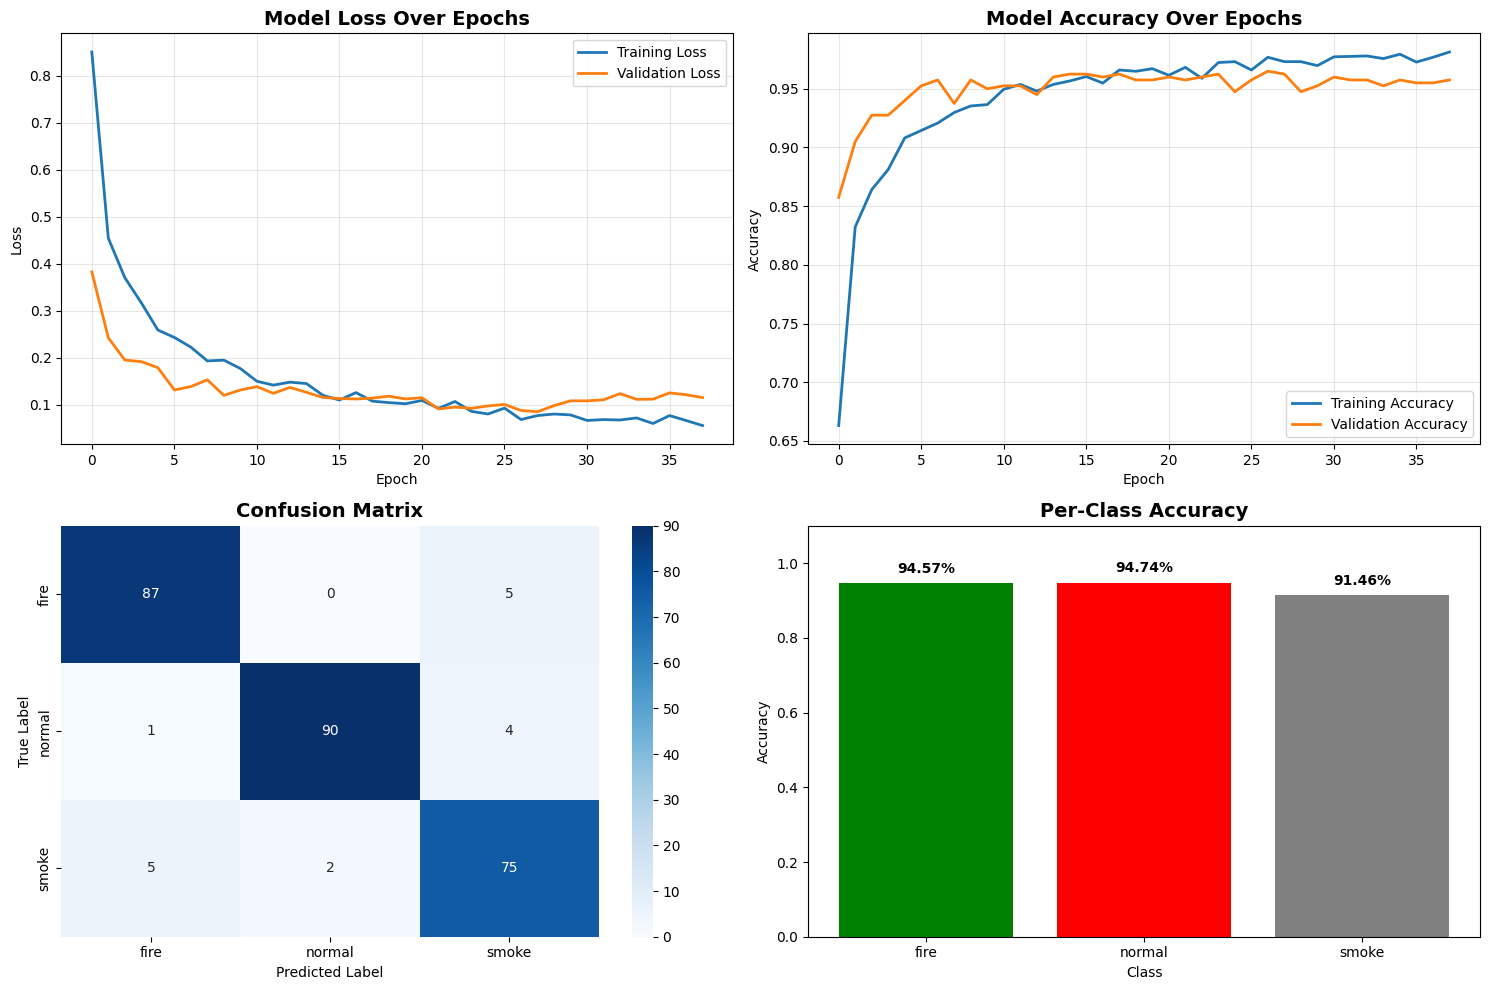

In [55]:
def plot_results(history, cm):
    plt.style.use('default')
    fig = plt.figure(figsize=(15, 10))
    
    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # Confusion Matrix
    plt.subplot(2, 2, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=lb.classes_,
                yticklabels=lb.classes_)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Per-class Accuracy
    plt.subplot(2, 2, 4)
    class_acc = cm.diagonal() / cm.sum(axis=1)
    bars = plt.bar(lb.classes_, class_acc, color=['green', 'red', 'gray'])
    plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.1])
    
    for bar, acc in zip(bars, class_acc):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_results(history, cm)


**Training Summar**y

In [56]:
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final Test Accuracy: {np.mean(pred_classes == true_classes):.4f}")
print(f"Total Training Time: {len(history.history['loss'])} epochs")



TRAINING SUMMARY
Best Validation Accuracy: 0.9650
Final Test Accuracy: 0.9368
Total Training Time: 38 epochs
